In [142]:
import gzip
from sklearn import metrics
import math
import matplotlib.pyplot as plt
import numpy
import json
import random
import scipy
import sklearn
import string
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from collections import defaultdict # Dictionaries that take a default for missing entries
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import scipy.special
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. Download and save to your own directory

In [143]:
dataDir = "Data"

# Sigmoid Function

In [144]:
def sigmoid(x):
    return 1.0 / (1.0 + math.exp(-x))

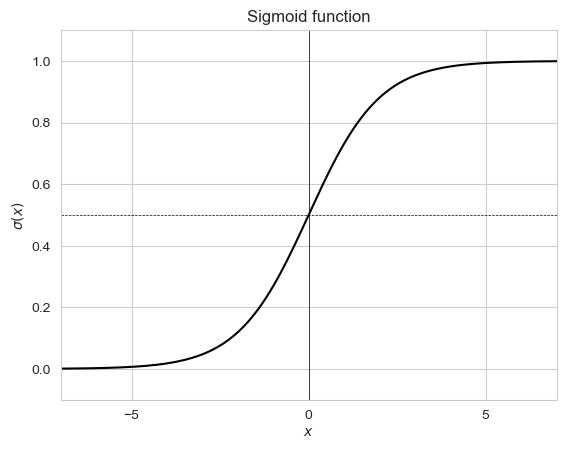

In [145]:
X = numpy.arange(-7,7.1,0.1)
Y = [sigmoid(x) for x in X]
plt.plot(X, Y, color='black')
plt.plot([0,0],[-2,2], color = 'black', linewidth=0.5)
plt.plot([-7,7],[0.5,0.5], color = 'k', linewidth=0.5, linestyle='--')
plt.xlim(-7, 7)
plt.ylim(-0.1, 1.1)
plt.xticks([-5,0,5])
plt.xlabel("$x$")
plt.ylabel(r"$\sigma(x)$")
plt.title("Sigmoid function")
plt.show()

# Tanh Function

In [146]:
def tanh(x):
    return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

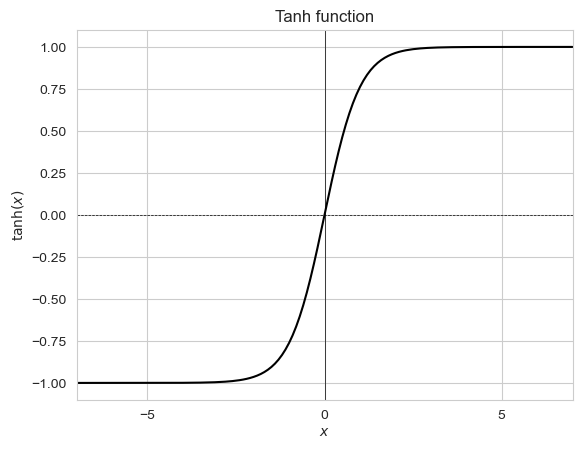

In [147]:
X = numpy.arange(-7, 7.1, 0.1)
Y = [tanh(x) for x in X]

plt.plot(X, Y, color='black')
plt.plot([0, 0], [-2, 2], color='black', linewidth=0.5)
plt.plot([-7, 7], [0, 0], color='k', linewidth=0.5, linestyle='--')
plt.xlim(-7, 7)
plt.ylim(-1.1, 1.1)
plt.xticks([-5, 0, 5])
plt.xlabel("$x$")
plt.ylabel(r"$\tanh(x)$")
plt.title("Tanh function")
plt.show()


# RELU Function

In [148]:
def relu(x):
    return max(0, x)

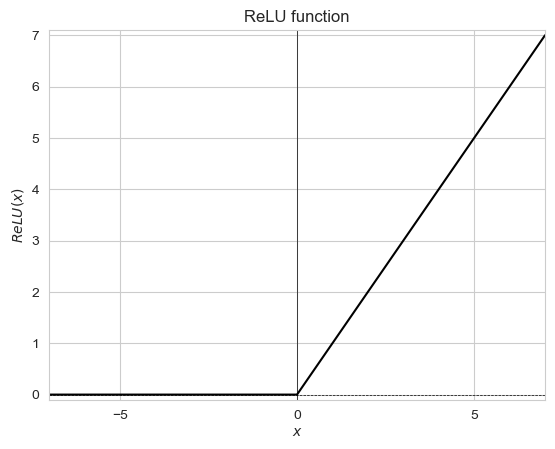

In [149]:
X = numpy.arange(-7, 7.1, 0.1)
Y = [relu(x) for x in X]

plt.plot(X, Y, color='black')
plt.plot([0, 0], [-2, 8], color='black', linewidth=0.5)
plt.plot([-7, 7], [0, 0], color='k', linewidth=0.5, linestyle='--')
plt.xlim(-7, 7)
plt.ylim(-0.1, 7.1)
plt.xticks([-5, 0, 5])
plt.xlabel("$x$")
plt.ylabel(r"$ReLU(x)$")
plt.title("ReLU function")
plt.show()

# Implementing a simple classifier

In [150]:
path = dataDir + "amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz"
f = gzip.open(path, 'rt', encoding="utf8")

header = f.readline()
header = header.strip().split('\t')

In [151]:
header

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [152]:
data = []

for line in f:
    fields = line.strip().split('\t')
    d = dict(zip(header, fields))
    d['star_rating'] = int(d['star_rating'])
    d['helpful_votes'] = int(d['helpful_votes'])
    d['total_votes'] = int(d['total_votes'])
    data.append(d)

One row of the dataset (as a python dictionary)

In [153]:
data[0]

{'marketplace': 'US',
 'customer_id': '45610553',
 'review_id': 'RMDCHWD0Y5OZ9',
 'product_id': 'B00HH62VB6',
 'product_parent': '618218723',
 'product_title': 'AGPtek® 10 Isolated Output 9V 12V 18V Guitar Pedal Board Power Supply Effect Pedals with Isolated Short Cricuit / Overcurrent Protection',
 'product_category': 'Musical Instruments',
 'star_rating': 3,
 'helpful_votes': 0,
 'total_votes': 1,
 'vine': 'N',
 'verified_purchase': 'N',
 'review_headline': 'Three Stars',
 'review_body': 'Works very good, but induces ALOT of noise.',
 'review_date': '2015-08-31'}

Predict whether a review is a verified purchased based on the length of their review

In [154]:
X = [[1, len(d['review_body'])] for d in data]
y =[1 if d['verified_purchase'] == 'Y' else 0 for d in data]

Fit the model

In [155]:
mod = sklearn.linear_model.LogisticRegression(fit_intercept=False)
mod.fit(X,y)

LogisticRegression(fit_intercept=False)

Calculate the accuracy of the model

In [156]:
predictions = mod.predict(X) # Binary vector of predictions
correct = predictions == y # Binary vector indicating which predictions were correct
sum(correct) / len(correct)

0.8639801495415936

This means 13.6%  are non-verified purchases (class 0), and the remaining 86.4% are verified purchases(class 1).

In [157]:
1 - (sum(y) / len(y))

0.13612595535857375

The model predicts 893,729 purchases as verified. Dataset is highly imbalanced — majority reviews are from verified purchases.

In [158]:
sum(predictions)

893729

# Implementing a balanced classifier

Use the class_weight='balanced' option to implement the balanced classifier



In [159]:
mod = sklearn.linear_model.LogisticRegression(class_weight='balanced')
mod.fit(X,y)
predictions = mod.predict(X)

# Simple classification diagnostics

### Accuracy

Compute the accuracy of the balanced model

In [160]:
correct = predictions == y
sum(correct) / len(correct)

0.7654551181798589

### True positives, False positives (etc.), and balanced error rate (BER

In [161]:
TP = sum([(p and l) for (p,l) in zip(predictions, y)])
FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
FN = sum([(not p and l) for (p,l) in zip(predictions, y)])

In [162]:
print("TP = " + str(TP))
print("FP = " + str(FP))
print("TN = " + str(TN))
print("FN = " + str(FN))

TP = 633548
FP = 64153
TN = 59009
FN = 148055


In [163]:
(TP + TN) / (TP + FP + TN + FN)

0.7654551181798589

### True positive and true negative rates

In [164]:
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

In [165]:
TPR,TNR

(0.8105751897062831, 0.479116935418392)

### Balanced Error Rate(BER)

In [166]:
BER = 1 - 1/2 * (TPR + TNR)
BER

0.35515393743766244

### Precision, recall, and F1 scores

In [167]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [168]:
precision, recall

(0.9080508699285224, 0.8105751897062831)

In [169]:
F1 = 2 * (precision*recall) / (precision + recall)
F1

0.8565487553606289

### Calculate ROC Curve

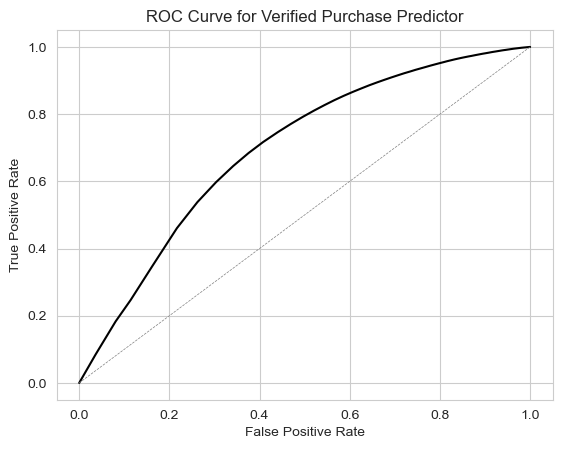

In [170]:

y = [1 if d['verified_purchase'] == 'Y' else 0 for d in data]


probs = mod.predict_proba(X)[:, 1]


probY = [(probs[i], None, y[i]) for i in range(len(y))]

xROC = []
yROC = []

for thresh in numpy.arange(0, 1.01, 0.01):
    preds = [x[0] > thresh for x in probY]
    labs = [x[2] for x in probY]

    TP = sum([(a and b) for (a, b) in zip(preds, labs)])
    FP = sum([(a and not b) for (a, b) in zip(preds, labs)])
    TN = sum([(not a and not b) for (a, b) in zip(preds, labs)])
    FN = sum([(not a and b) for (a, b) in zip(preds, labs)])

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (TN + FP) if (TN + FP) > 0 else 0

    xROC.append(FPR)
    yROC.append(TPR)

plt.plot(xROC, yROC, color='black')
plt.plot([0, 1], [0, 1], lw=0.5, color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Verified Purchase Predictor")
plt.show()

## Multi Class Logistic Regression with Softmax

Predict star rating based on review body

In [171]:
vectorizer = TfidfVectorizer()


X = vectorizer.fit_transform([d['review_body'] for d in data])


y = [d['star_rating'] for d in data]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4)



model = LogisticRegression(max_iter=800, random_state=42)
model.fit(X_train, y_train)


logits = model.decision_function(X_test)  # raw scores
probs = scipy.special.softmax(logits, axis=1)  # apply softmax--> convert to probabilities


print("Predicted class probabilities:\n", probs)

#Evaluate model
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Predicted class probabilities:
 [[3.36283921e-05 6.05676436e-05 1.49792840e-03 7.45533953e-02
  9.23854480e-01]
 [3.29659972e-03 6.34176297e-03 6.32746442e-03 5.59015308e-02
  9.28132642e-01]
 [8.21336971e-04 6.51741164e-04 1.42540541e-03 2.17889823e-02
  9.75312534e-01]
 ...
 [1.76225677e-04 4.41124078e-04 2.54741539e-02 3.60515476e-01
  6.13393020e-01]
 [7.96501783e-04 5.06531453e-03 5.93910676e-02 6.97159891e-01
  2.37587225e-01]
 [1.76225677e-04 4.41124078e-04 2.54741539e-02 3.60515476e-01
  6.13393020e-01]]

Classification Report:
               precision    recall  f1-score   support

           1       0.63      0.70      0.67     26430
           2       0.36      0.13      0.19     16064
           3       0.40      0.25      0.31     26765
           4       0.47      0.25      0.33     63090
           5       0.78      0.94      0.86    229557

    accuracy                           0.72    361906
   macro avg       0.53      0.46      0.47    361906
weighted avg       0.67

## Support Vector Machine

Use linear SVM to predict star ratings from review body

In [172]:
vectorizer = TfidfVectorizer()


X = vectorizer.fit_transform([d['review_body'] for d in data])


y = [d['star_rating'] for d in data]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4)



svc_model = LinearSVC(random_state=42)
svc_model.fit(X_train, y_train)


y_pred = svc_model.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.70      0.65     26430
           2       0.32      0.07      0.11     16064
           3       0.40      0.17      0.23     26765
           4       0.44      0.23      0.31     63090
           5       0.77      0.95      0.85    229557

    accuracy                           0.71    361906
   macro avg       0.51      0.42      0.43    361906
weighted avg       0.65      0.71      0.66    361906



Imbalanced data is causing the model to favor the majority class (5), leading to lower performance on minority classes.

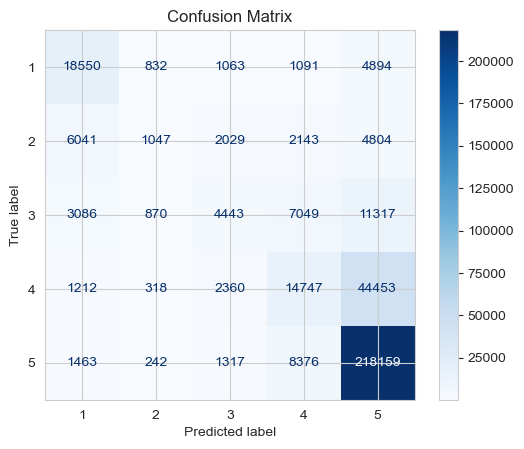

In [173]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# KNN

Use KNN to predict star ratings based on review length, helpful votes, and total votes

In [174]:
X = [[len(d['review_body']), d['helpful_votes'], d['total_votes']] for d in data]
y = [d['star_rating'] for d in data]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


knn = KNeighborsClassifier(n_neighbors=3)  
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.22      0.19     19778
           2       0.06      0.07      0.07     12035
           3       0.09      0.07      0.08     20005
           4       0.18      0.09      0.12     47397
           5       0.66      0.74      0.70    172215

    accuracy                           0.51    271430
   macro avg       0.23      0.24      0.23    271430
weighted avg       0.47      0.51      0.49    271430



Evaluate KNN performance for k = 1 to 30

In [175]:
k_vals = [i for i in range (1,31)]
kscores = []

standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    kscore = cross_val_score(knn, X, y, cv=5)
    kscores.append(numpy.mean(kscore))

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


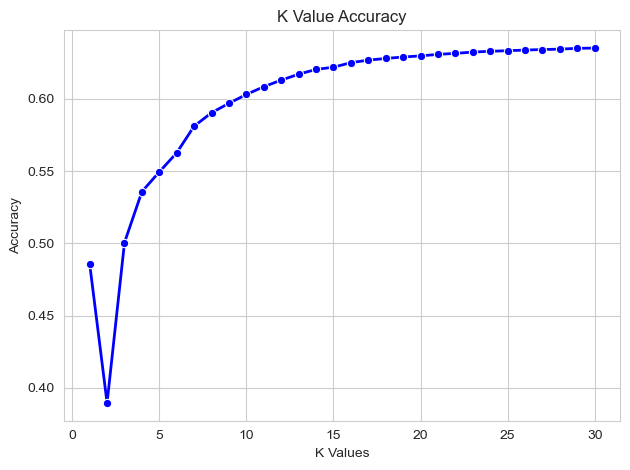

In [176]:

sns.lineplot(x=k_vals, y=kscores, marker='o', color='blue', linewidth=2)
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.title("K Value Accuracy")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout() 

Since ratings are unevenly distributed, we can perform stratified k-fold cross-validation, which gives a more stable, averaged estimate of model performance 

In [177]:
X = numpy.array([[len(d['review_body']), d['helpful_votes'], d['total_votes']] for d in data])
y = numpy.array([d['star_rating'] for d in data])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}")
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)


    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    accuracies.append(acc)

print("Average Accuracy across folds:", numpy.mean(accuracies))



Fold 1
              precision    recall  f1-score   support

           1       0.14      0.27      0.18     22047
           2       0.06      0.07      0.06     13377
           3       0.09      0.07      0.08     22349
           4       0.20      0.08      0.11     52844
           5       0.67      0.71      0.69    190972

    accuracy                           0.49    301589
   macro avg       0.23      0.24      0.22    301589
weighted avg       0.48      0.49      0.48    301589

Accuracy: 0.49

Fold 2
              precision    recall  f1-score   support

           1       0.13      0.26      0.18     22047
           2       0.06      0.08      0.07     13376
           3       0.08      0.08      0.08     22348
           4       0.19      0.08      0.11     52844
           5       0.66      0.68      0.67    190973

    accuracy                           0.47    301588
   macro avg       0.23      0.24      0.22    301588
weighted avg       0.47      0.47      0.47   